# Why do competitors open their stores next to one another ?

A couple of days back, I was browsing YouTube and saw a Ted-Ed video in my recommendations. The title of the video was 
_Why do competitors open their stores next to one another?_. This is one of those questions which would occur in my mind from time to time but I never bothered to find an answer. There have been occasions when I had been driving for hours without seeing a petrol station, but when you spot one, you see a couple more clustered together as well.

Naturally, I watched the video and learnt that this can be explained using principles of game theory and Nash equilibrium. The video gave an interactive and simple explaination and you should definitely watch it - 

> youtube: https://www.youtube.com/embed/jILgxeNBK_8

In [1]:
#hide
#from IPython.display import IFrame
#IFrame(src='https://www.youtube.com/embed/jILgxeNBK_8', width='600', height='300')

Now this video gave a great explaination but this time I wanted to see if we get the same results using data.

_Disclaimer : I've tried to list down all the assumptions that I have taken to model this problem. If you see things that are incorrect or incomplete, please let me know._ 

In [2]:
#hide
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import random

To start with let us create a city and lay out customers in it.

For this problem, I am creating a 1 x 1 grid representing a city and 1000 customers distributed uniformly in the grid.

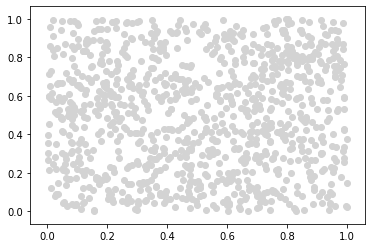

In [3]:
customers = np.random.uniform(0, 1, (1000,2))
plt.scatter(customers[:,0], customers[:,1], c = 'lightgrey');

Now, let's add stores in the city.

We'll assume that the stores are initially randomly distributed and they are all attempting to reach to an optimal position in the city. We'll see the definition of an optimal position in later part of the post.

In [4]:
num_stores = 6
stores = np.random.uniform(0, 1., (num_stores,2))

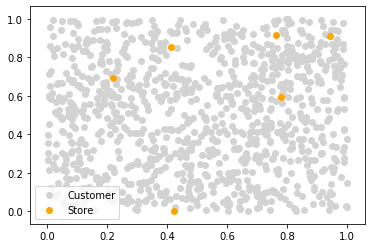

In [5]:
c = plt.scatter(customers[:,0], customers[:,1], c = 'lightgrey')
s = plt.scatter(stores[:,0], stores[:,1], c = 'orange')
plt.legend((c, s),
           ('Customer', 'Store'),
           scatterpoints=1,
           loc='lower left')
plt.show()

Now that we have a basic problem set-up, let us try to come up with a criteria that a store would use to maximize its sales. To simplify the problem, we'll assume that all the stores are identical in liking and customers use distance as the only criteria to buy from a store.

In a setting when there is only one store in the city, the optimal position would be the one that minimizes the average distance customers have to travel to reach the store. Let us call this distance $d_{min}$.
In case a second store comes up in the city, the optimal position for it would be to place itself in a way that it is as close as possible to $d_{min}$. The intuition behind this idea if the second store is too far, the customers are likely to visit the first store.

If we extend these ideas to a multi-store setting with $N$ customers, every store in the city would want to:
- Be as closer as the nearest store to the customers i.e. minimize

$$
{minimize} \ \ \frac{1}{N}\sum_{i}^{N} \frac{distance \left ( \ customer_{i}, neareast {\_} store_{i}  \ \right )}{distance \left ( \ customer_{i}, store  \ \right )} 
$$

- Minimize the average distance customers have to travel to reach the store

$$
{minimize} \ \ \frac{1}{N}\sum_{i}^{N}distance\left ( \ customer_{i} \ - store \ \right )
$$

Combining these two objectives, the overall objective for a store is to 

$$
{minimize} \left ( \ \frac{1}{N}\sum_{i}^{N} \frac{distance \left ( \ customer_{i}, \ neareast {\_} store_{i}  \ \right )}{distance \left ( \ customer_{i}, \ store  \ \right )} 
\ + \ \ \frac{1}{N}\sum_{i}^{N}distance\left ( \ customer_{i} \ -  store \ \right ) \right )
\\
$$

For the multi-store setting with $N$ customers and $M$ stores, the overall objective becomes

$$
{minimize} \left ( \ \frac{1}{M} \sum_{j}^{M} \left ( \ \frac{1}{N}\sum_{i}^{N} \frac{distance \left ( \ customer_{i}, \ neareast {\_} store_{i} \ \right )}{distance \left ( \ customer_{i}, \ store_{j}  \ \right )} 
\ + \ \ \frac{1}{N}\sum_{i}^{N}distance\left ( \ customer_{i} \ -  store_{j} \ \right ) \right ) \right )
\\
\\
$$

Now that the entire problem had reduced to a minimization problem, we can use gradient descent to reach the optimal solution.

In [6]:
# hide
stores = torch.tensor(stores)
stores = stores.reshape(-1,1,2)
stores = torch.nn.Parameter(stores)

In [7]:
# hide
customers

array([[0.79761426, 0.16132312],
       [0.61768994, 0.89780142],
       [0.62693482, 0.78517124],
       ...,
       [0.81455302, 0.85382255],
       [0.12991107, 0.88487907],
       [0.16418749, 0.16757727]])

Let us start by creating store to customer distance vectors. For every store we'll calculate its distance from each customer. Thus for each store, we'll have $N$x$1$ vector.
Since there are $M$ stores, the final output matrix would be of size $M$x$N$.

In [8]:
def calculate_store_to_customer_distances(stores, customers):
    res = (stores - customers)**2
    res = res.sum(dim=2)
    res = torch.sqrt(res)
    return res

The objective function is our case becomes a loss function which we will backpropagate.

In [9]:
def loss_fn(stores, customers):
    
    store_customer_distance = calculate_store_to_customer_distances(stores, customers)

    # Be as closer as the nearest store
    min_store_customer_distance = store_customer_distance.min(0)[0]
    store_losses = 1. - ( min_store_customer_distance + 1e-7 ) / store_customer_distance
    store_losses = store_losses.sum(0).sum(0)    
    total_store_customer_pairs = torch.numel(store_customer_distance)
    loss =  store_losses / total_store_customer_pairs
    
    # minimize average distance customers have to travel to reach the store
    average_store_customer_distance = store_customer_distance.sum(0).sum(0) / total_store_customer_pairs
    loss += average_store_customer_distance
    
    return loss

In [10]:
# hide
customers = torch.tensor(customers)

Now that the data and the loss is defined, let us calcualte gradients and allow backpropagation to do its magic.

In [22]:
optimizer = torch.optim.SGD([stores], lr=1e-2)

In [23]:
for i in range(1,51):
    optimizer.zero_grad()
    loss = loss_fn(stores, customers)
    if i%10 == 0:
        print('At Epoch {0}, loss {1}'.format(i, loss))
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        stores[stores < 0] = 0.
        stores[stores > 1] = 1.

At Epoch 10, loss 0.40850992142825726
At Epoch 20, loss 0.3922313790948716
At Epoch 30, loss 0.39296911156435976
At Epoch 40, loss 0.3951459774244648
At Epoch 50, loss 0.39564915895903785


Since the loss function doesn't seem to change a lot, let us see the current state of the stores in grid.

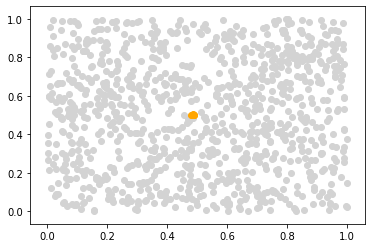

In [24]:
plt.scatter(customers[:,0], customers[:,1], c = 'lightgrey')
t = stores.reshape(-1,2).detach().numpy()
plt.scatter(t[:,0], t[:,1], c = 'orange')
plt.show()

Voila! All the stores appear to be together.

They all seem to be around the mid-point of the city. Let's see their co-ordinates.

In [25]:
stores.reshape(num_stores,-1)

tensor([[0.4859, 0.5026],
        [0.4880, 0.5019],
        [0.4867, 0.5009],
        [0.4892, 0.5004],
        [0.4869, 0.5078],
        [0.4807, 0.5016]], dtype=torch.float64, grad_fn=<ViewBackward>)

All of them are around (0.5, 0.5) which seems sensible because their presence at mid-point would would offer equal reach in all the directions of a store.


So that’s it for today. 

It was really fun for me to find out an answer for this problem and I hope that you enjoyed reading it. Feel free to post any questions and suggestions in the comment section. I will be happy to answer them.